## LangGraph Retrieval GroundCheck

### 환경설정

In [7]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [4]:
# !pip install langchain_upstage


In [8]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["../12-RAG/data/1568)누구나 한번쯤 읽어야 할 사서삼경 (미리내공방) .pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

### GraphState

In [9]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

### 노드와 엣지

주요 개념

- GraphState(상태 저장 그래프): LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- Node(노드): 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- Edge(엣지): 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.

In [10]:
from rag.utils import format_docs
from langchain_upstage import UpstageGroundednessCheck

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()

# 업스테이지 문서 관련성 체크를 실행합니다.
upstage_ground_checker.run(
    {
        "context": format_docs(
            pdf_retriever.invoke("삼성전자가 개발한 생성AI 의 이름은")
        ),
        "answer": "삼성전자가 개발한 생성AI 의 이름은 `빅스비 AI` 입니다.",
    }
)

'notGrounded'

In [11]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=format_docs(retrieved_docs))


# Chain을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer=pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        )
    )

In [12]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=format_docs(retrieved_docs))


# Chain을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer=pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        ),
        context=state["context"],
        question=state["question"],
    )


# 테스트용 더미 답변 생성 함수
def fake_llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer="삼성전자가 개발한 생성AI 의 이름은 `빅스비 AI` 입니다.",
        context=state["context"],
        question=state["question"],
    )


# 관련성 체크를 실행합니다.
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )


# 관련성 체크 결과를 반환합니다.
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

### 그래프 정의

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.

# 테스트용 fake llm 을 추가합니다.
# workflow.add_node("llm_answer", fake_llm_answer)  # 정보 검색 노드를 추가합니다.


workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": END,  # 관련성이 있으면 종료합니다.
        "관련성 X": "retrieve",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "retrieve",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

### 그래프 시각화

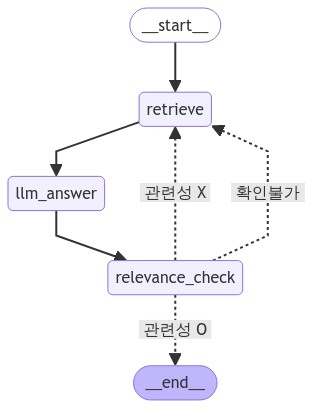

In [14]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [17]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=13, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="삼성전자가 개발한 생성형 AI의 이름은?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])
# RateLimitError 발생 - API 사용 한도 초과

In [18]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=13, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="삼성전자가 개발한 생성형 AI의 이름은?")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

'[NODE] retrieve'
('<context> <document><content>자 왈 개 유 부 지 이 작 지 자 아 무 시 야\n'
 '子曰 蓋有不知而作之者 我無是也\n'
 '다 문 택 기 선 자 이 종 지 다 견 이 식 지 지 지 차 야\n'
 '多聞 擇其善者而從之 多見而識之 知之次也\n'
 '공자가 말했다. 제대로 알지도 못하면서 새로운 것을 창작하려는 사람이 있\n'
 '으나 나는 그렇지 않다. 나는 우선 많은 것을 들은 다음 그중 취해도 좋은 것\n'
 '을 가려내어 본받는다. 또한 많이 본 다음 그중에서 내가 취해도 좋을 것을\n'
 '가려내어 기억해둔다. 이것이 바로 ‘안다’는 것이며, 나면서부터 아는 것의\n'
 '다음이다. _술이(述而) 27\n'
 '※ 여기서 공자가 말한 ‘안다’는 것은 크게 세 가지로 나눌 수 있다. 첫 번째는 나면서\n'
 '부터 아는 것(생이지지, 生而知之), 즉 배우지 않고서도 스스로 깨우치는 것을 말하는\n'
 '데 흔히 천재들을 여기에 비한다. 그다음이 배워서 아는 것(학이지지, 學而知之)이고,\n'
 '마지막이 고생한 끝에 알게 되는 것(곤이지지, 困而知之)이다. 어떤 경우이건 알고 '
 '난</content><source>../12-RAG/data/1568)누구나 한번쯤 읽어야 할 사서삼경 (미리내공방) '
 '.pdf</source><page>82</page></document>\n'
 '<document><content>누구나 한번쯤\n'
 '읽어야 할 사서삼경\n'
 '1판 1쇄 인쇄2 018년 7월 6일\n'
 '1판 1쇄 발행 2018년 7월 13일\n'
 '엮은이 | 미리내공방\n'
 '펴낸이 | 최윤하\n'
 '펴낸곳 | 정민미디어\n'
 '주 소 | (151-834) 서울시 관악구 행운동 1666-45, F\n'
 '전 화 | 02-888-0991\n'
 '팩 스 | 02-871-0995\n'
 '이메일 | pceo@daum.net\n'
 '홈페이지 | www.hyuneum.com\n'


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [20]:
print("Question: \t", output["relevance_check"]["question"])
print("Answer: \t", output["relevance_check"]["answer"])
print("Relevance: \t", output["relevance_check"]["relevance"])